In [1]:
%matplotlib inline
!pip install tensorboardcolab

import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import tensorboardcolab

Using TensorFlow backend.


In [2]:
# load cifar10 dataset 
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


In [3]:
# reshape (None, 1) -> (None)
y_train, y_test = [np.reshape(y_train, [-1]), np.reshape(y_test, [-1])]

# normalization 
x_train, x_test = [(x_train - x_train.max()) / (x_train.max() - x_train.min()),
                   (x_test - x_test.max()) / (x_test.max() - x_test.min())]

# N class
n_classes = 10
print('image shape : {}, label shape : {} '.format(x_train.shape, y_train.shape))
print('image shape : {}, label shape : {} '.format(x_test.shape, y_test.shape))
print('train minimun : {}, train_maximum : {} '.format(x_train.min(), x_train.max()))
print('tests minimun : {}, test_maximum : {} '.format(x_test.min(), x_test.max()))

image shape : (50000, 32, 32, 3), label shape : (50000,) 
image shape : (10000, 32, 32, 3), label shape : (10000,) 
train minimun : 0.0, train_maximum : 1.0 
tests minimun : 0.0, test_maximum : 1.0 


In [4]:
temp = x_train
ratio = int(len(x_train) * 0.7)
ratio_end = int(len(x_train) * 0.85)

x_train = temp[0:ratio, :, :, :]
x_validation = temp[ratio:ratio_end , :, :, :]

y_train_label = y_train[0:ratio]
y_validation_label = y_train[ratio:ratio_end ]

print(y_train_label[:10]) # label이 one_hot encoding상태가 아니다.

print(x_train.shape, y_train_label.shape)
print(x_validation.shape, y_validation_label.shape)

[6 9 9 4 1 1 2 7 8 3]
(35000, 32, 32, 3) (35000,)
(7500, 32, 32, 3) (7500,)


## Data Provider

In [0]:
class DataProvider(object):
    def __init__(self, x, y):
        self.epoch_count = 0
        
        self.data = x
        self.label = y
        
        npr.seed(42)
        
        self.indices = self.generate_indices()
        
    def generate_indices(self):
        indices = list(range(len(self.data)))
        npr.shuffle(indices)
        
        return indices
    
    def next_batch(self, batch_size):
        idx = batch_size
        if len(self.indices) < batch_size:
            print("all data consumed, epoch + 1")
            self.epoch_count += 1
            self.indices = self.generate_indices()
    
        target_indices = self.indices[:batch_size]
        del self.indices[:batch_size]
        
        return self.data[target_indices] , self.label[target_indices]

In [0]:
def cifar_generator(data, labels, batch_size=32):
    start_idx = 0
    num_step = len(data) // batch_size
    indexes = np.arange(0, len(data))
    while True:
        if start_idx >= num_step-1:
            np.random.shuffle(indexes)
            start_idx = 0
        else:
            start_idx += 1            
        batch_index = indexes[start_idx*batch_size:
                              (start_idx+1)*batch_size]

        batch_data = data[batch_index]
        batch_label = labels[batch_index]

        yield batch_data, batch_label

## Model A : Build

In [7]:
graph = tf.Graph()
with graph.as_default() :
    xs = tf.placeholder(tf.float32, (None, 32, 32, 3), name='xs')
    ys = tf.placeholder(tf.int32, (None), name='ys')
    lr = tf.placeholder_with_default(0.001, (), name='lr')
    wd = tf.placeholder_with_default(0.9, (), name='wd')
    is_train = tf.placeholder_with_default(False, (), name='is_train')
    
    with tf.name_scope('conv1') :  
        # he_init
        kernel_init = tf.random.normal(shape=[2, 2, 3, 16], mean=0.0, stddev=0.1, dtype=tf.float32) 
        bias_init   = tf.zeros([16])
        kernel      = tf.Variable(kernel_init, name='kernel1')               
        bias        = tf.Variable(bias_init, name='bias1')    
        layer       = tf.nn.conv2d(xs, kernel, strides=[1,1,1,1], padding='SAME') 
        layer       = layer + bias
        layer       = tf.nn.relu(layer)
        pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)      
        
    with tf.name_scope('conv2') : 
        kernel_init = tf.random.normal(shape=[2, 2, 16, 32], mean=0.0, stddev=0.1, dtype=tf.float32) 
        bias_init   = tf.zeros([32])
        kernel      = tf.Variable(kernel_init, name='kernel1')    
        bias        = tf.Variable(bias_init, name='bias1')    
        layer       = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME')    
        layer       = layer + bias
        layer       = tf.nn.relu(layer)      
        pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)          

    with tf.name_scope('conv3') :   
        kernel_init = tf.random.normal(shape=[2, 2, 32, 64], mean=0.0, stddev=0.1, dtype=tf.float32) 
        bias_init   = tf.zeros([64])
        kernel      = tf.Variable(kernel_init, name='kernel1')    
        bias        = tf.Variable(bias_init, name='bias1')    
        layer       = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME')    
        layer       = layer + bias
        layer       = tf.nn.relu(layer)       
        
        kernel_init = tf.random.normal(shape=[2, 2, 64, 64], mean=0.0, stddev=0.1, dtype=tf.float32) 
        bias_init   = tf.zeros([64])
        kernel      = tf.Variable(kernel_init, name='kernel2')    
        bias        = tf.Variable(bias_init, name='bias2')    
        layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME')    
        layer       = layer + bias
        layer       = tf.nn.relu(layer) 
        pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)    

    with tf.name_scope('conv4') :   
        kernel_init = tf.random.normal(shape=[2, 2, 64, 128], mean=0.0, stddev=0.1, dtype=tf.float32) 
        bias_init   = tf.zeros([128])
        kernel      = tf.Variable(kernel_init, name='kernel1')    
        bias        = tf.Variable(bias_init, name='bias1')    
        layer       = tf.nn.conv2d(pool, kernel, strides=[1,1,1,1], padding='SAME')    
        layer       = layer + bias
        layer       = tf.nn.relu(layer)   
        
        kernel_init = tf.random.normal(shape=[2, 2, 128, 128], mean=0.0, stddev=0.1, dtype=tf.float32) 
        bias_init   = tf.zeros([128])
        kernel      = tf.Variable(kernel_init, name='kernel2')    
        bias        = tf.Variable(bias_init, name='bias2')    
        layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME')    
        layer       = layer + bias
        layer       = tf.nn.relu(layer)       
        pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)   

    # with tf.name_scope('conv5') :   
    #     kernel_init = tf.random.normal(shape=[2, 2, 128, 128], mean=0.0, stddev=0.1, dtype=tf.float32) 
    #     bias_init   = tf.zeros([128])
    #     kernel      = tf.Variable(kernel_init, name='kernel1')    
    #     bias        = tf.Variable(bias_init, name='bias1')    
    #     layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME')    
    #     layer       = layer + bias
    #     layer       = tf.nn.relu(layer)   
    #     
    #     kernel_init = tf.random.normal(shape=[2, 2, 128, 128], mean=0.0, stddev=0.1, dtype=tf.float32) 
    #     bias_init   = tf.zeros([128])
    #     kernel      = tf.Variable(kernel_init, name='kernel2')    
    #     bias        = tf.Variable(bias_init, name='bias2')    
    #     layer       = tf.nn.conv2d(layer, kernel, strides=[1,1,1,1], padding='SAME')    
    #     layer       = layer + bias
    #     layer       = tf.nn.relu(layer)       
    #     pool        = tf.layers.MaxPooling2D(pool_size=[2,2], strides=[2,2])(layer)           

    with tf.name_scope('fc1') : 
        flatten       = tf.layers.flatten(pool)
        
        he_init       = tf.sqrt(2 / 1024) # HighLevel API로 변경해보자.
        kernel_init   = tf.random.normal(shape = [512, 1024], mean=0.0, stddev=he_init, dtype = tf.float32)
        kernel        = tf.Variable(kernel_init, name = "kernel1")
        bias          = tf.Variable(tf.zeros([1024]), name = "bias1")
        z             = tf.matmul(flatten, kernel) + bias
        logits        = tf.nn.relu(z)
        dropout       = tf.layers.Dropout(0.5)(logits, training = is_train)

    with tf.name_scope('fc2') : 
        he_init       = tf.sqrt(2 / 1024)
        kernel_init   = tf.random.normal(shape = [1024, 1024], mean=0.0, stddev=he_init, dtype = tf.float32)
        kernel        = tf.Variable(kernel_init, name = "kernel1")
        bias          = tf.Variable(tf.zeros([1024]), name = "bias1")
        z             = tf.matmul(dropout, kernel) + bias
        logits        = tf.nn.relu(z)
        dropout       = tf.layers.Dropout(0.5)(logits, training = is_train)

    with tf.name_scope('fc3') : 
        he_init       = tf.sqrt(2 / 512)
        kernel_init   = tf.random.normal(shape = [1024, 512], mean=0.0, stddev=he_init, dtype = tf.float32)
        kernel        = tf.Variable(kernel_init, name = "kernel1")
        bias          = tf.Variable(tf.zeros([512]), name = "bias1")
        z             = tf.matmul(dropout, kernel) + bias
        logits        = tf.nn.relu(z)
        dropout       = tf.layers.Dropout(0.5)(logits, training = is_train)
        
        y_pred        = tf.layers.Dense(10, activation=None, name='y_pred')(dropout) 
        
    with tf.name_scope('Loss') :
        sce_loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(labels=ys, logits=y_pred))
        l2_loss = tf.add_n([tf.nn.l2_loss(var) for var in tf.global_variables()])
        loss = sce_loss + wd * l2_loss
    loss = tf.identity(loss, name='loss')
        
    with tf.name_scope('metric') :
        rmse = tf.sqrt(loss)
    
    with tf.name_scope('accuracy') :
        pred = tf.cast(tf.arg_max(y_pred, 1), tf.int32)
        correct = tf.equal(pred, ys)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
        # add tensor to tensorboard
        acc_tb = tf.summary.scalar(name='accuracy', tensor=accuracy)

    with tf.name_scope('train') :
        global_step = tf.train.get_or_create_global_step()
        train_op = tf.train.AdamOptimizer(lr).minimize(loss, global_step = global_step)

W0619 08:48:13.564095 139703660300160 deprecation.py:323] From <ipython-input-7-767b07a22a15>:85: flatten (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.flatten instead.
W0619 08:48:13.890820 139703660300160 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0619 08:48:14.305937 139703660300160 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/losses/losses_impl.py:121: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the

## Model A : Train

In [8]:
with graph.as_default() :
    
    # 텐서보드에 연결합니다. # sess.run보다 먼저 선언해야함. 
    log_dir = "./log/vgg_net_model_a"  
    lode_dir = None
    save_dir = "./model/vgg_net_model_a"   
    
    # tbc = tensorboardcolab.TensorBoardColab(graph_path = log_dir)
    
    train_writer = tf.summary.FileWriter(logdir = log_dir)
    train_writer.add_graph(tf.get_default_graph())
    merged_all = tf.summary.merge_all()    
    
    sess = tf.Session()
    sess.run([tf.global_variables_initializer(),
              tf.local_variables_initializer()])
    
    # Step2 : 기록
    saver = tf.train.Saver() # 다 저장하겠다.
    
    # Training
    batch_size = 500 
    n_epoch = 100
    n_step = int(len(x_train) // batch_size)  # //은 몫이다.
    learing_rate = 0.0001
    weight_decay = 0.0005
    
    # instance 생성
    train_generator = cifar_generator(x_train, y_train_label, batch_size)
    
    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []
    cnt = 0
    maximum_acc = 0.5
    for i in tqdm(range(n_epoch)) :
        for step in range(n_step) :
            batch_xs, batch_ys = next(train_generator)
            _, train_loss_, train_acc_ = sess.run([train_op, rmse, accuracy], 
                                               feed_dict = { xs: batch_xs, 
                                                             ys: batch_ys, 
                                                             lr: learing_rate,
                                                             wd : weight_decay,
                                                             is_train : True})
            train_loss.append(train_loss_)
            train_acc.append(train_acc_)
            
            # check validation set
            if step % 100 == 0 :
                loss_, acc_ = sess.run([rmse, accuracy], 
                                       feed_dict = { xs: x_validation, 
                                                     ys: y_validation_label,
                                                     wd : weight_decay,
                                                     is_train : False})
                valid_loss.append(loss_)
                valid_acc.append(acc_)
                
                # Save the model
                if acc_ > maximum_acc :
                    print("log current model! valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
                    maximum_acc = acc_
                    saver.save(sess, save_path = save_dir)
        print(" valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
    print(" valid loss = {:.4f}, valid acc = {:.2f}%".format(loss_, acc_*100))
    
    train_writer.flush() # file을 disk에 쓴다

  1%|          | 1/100 [00:07<12:09,  7.37s/it]

 valid loss = 1.9788, valid acc = 8.80%


  2%|▏         | 2/100 [00:09<09:26,  5.78s/it]

 valid loss = 1.9331, valid acc = 22.60%


  3%|▎         | 3/100 [00:11<07:31,  4.66s/it]

 valid loss = 1.8469, valid acc = 26.28%


  4%|▍         | 4/100 [00:13<06:11,  3.87s/it]

 valid loss = 1.7792, valid acc = 30.76%


  5%|▌         | 5/100 [00:15<05:15,  3.32s/it]

 valid loss = 1.7296, valid acc = 36.11%


  6%|▌         | 6/100 [00:17<04:36,  2.94s/it]

 valid loss = 1.6931, valid acc = 37.73%


  7%|▋         | 7/100 [00:19<04:08,  2.68s/it]

 valid loss = 1.6674, valid acc = 39.87%


  8%|▊         | 8/100 [00:21<03:51,  2.52s/it]

 valid loss = 1.6374, valid acc = 42.15%


  9%|▉         | 9/100 [00:23<03:37,  2.40s/it]

 valid loss = 1.6126, valid acc = 45.20%


 10%|█         | 10/100 [00:26<03:27,  2.31s/it]

 valid loss = 1.5968, valid acc = 45.55%


 11%|█         | 11/100 [00:28<03:19,  2.25s/it]

 valid loss = 1.5799, valid acc = 46.09%


 12%|█▏        | 12/100 [00:30<03:13,  2.20s/it]

 valid loss = 1.5691, valid acc = 47.03%


 13%|█▎        | 13/100 [00:32<03:08,  2.17s/it]

 valid loss = 1.5483, valid acc = 48.28%


 14%|█▍        | 14/100 [00:34<03:04,  2.15s/it]

 valid loss = 1.5346, valid acc = 49.71%


 15%|█▌        | 15/100 [00:36<03:01,  2.13s/it]

 valid loss = 1.5235, valid acc = 49.96%
log current model! valid loss = 1.5152, valid acc = 50.37%


 16%|█▌        | 16/100 [00:38<03:02,  2.17s/it]

 valid loss = 1.5152, valid acc = 50.37%
log current model! valid loss = 1.5003, valid acc = 51.25%


 17%|█▋        | 17/100 [00:41<03:01,  2.19s/it]

 valid loss = 1.5003, valid acc = 51.25%
log current model! valid loss = 1.4950, valid acc = 51.33%


 18%|█▊        | 18/100 [00:43<03:00,  2.20s/it]

 valid loss = 1.4950, valid acc = 51.33%
log current model! valid loss = 1.4789, valid acc = 52.93%


 19%|█▉        | 19/100 [00:45<02:58,  2.21s/it]

 valid loss = 1.4789, valid acc = 52.93%


 20%|██        | 20/100 [00:47<02:53,  2.17s/it]

 valid loss = 1.4739, valid acc = 52.71%
log current model! valid loss = 1.4609, valid acc = 53.87%


 21%|██        | 21/100 [00:49<02:53,  2.19s/it]

 valid loss = 1.4609, valid acc = 53.87%
log current model! valid loss = 1.4543, valid acc = 54.00%


 22%|██▏       | 22/100 [00:51<02:51,  2.20s/it]

 valid loss = 1.4543, valid acc = 54.00%
log current model! valid loss = 1.4488, valid acc = 54.52%


 23%|██▎       | 23/100 [00:54<02:49,  2.21s/it]

 valid loss = 1.4488, valid acc = 54.52%
log current model! valid loss = 1.4395, valid acc = 54.95%


 24%|██▍       | 24/100 [00:56<02:48,  2.22s/it]

 valid loss = 1.4395, valid acc = 54.95%
log current model! valid loss = 1.4301, valid acc = 55.72%


 25%|██▌       | 25/100 [00:58<02:46,  2.22s/it]

 valid loss = 1.4301, valid acc = 55.72%


 26%|██▌       | 26/100 [01:00<02:41,  2.19s/it]

 valid loss = 1.4334, valid acc = 54.95%


 27%|██▋       | 27/100 [01:02<02:38,  2.17s/it]

 valid loss = 1.4184, valid acc = 55.72%
log current model! valid loss = 1.4093, valid acc = 56.24%


 28%|██▊       | 28/100 [01:05<02:37,  2.19s/it]

 valid loss = 1.4093, valid acc = 56.24%
log current model! valid loss = 1.4035, valid acc = 56.99%


 29%|██▉       | 29/100 [01:07<02:36,  2.20s/it]

 valid loss = 1.4035, valid acc = 56.99%
log current model! valid loss = 1.3941, valid acc = 57.40%


 30%|███       | 30/100 [01:09<02:34,  2.21s/it]

 valid loss = 1.3941, valid acc = 57.40%
log current model! valid loss = 1.3874, valid acc = 58.11%


 31%|███       | 31/100 [01:11<02:32,  2.22s/it]

 valid loss = 1.3874, valid acc = 58.11%


 32%|███▏      | 32/100 [01:13<02:28,  2.18s/it]

 valid loss = 1.3889, valid acc = 57.05%
log current model! valid loss = 1.3766, valid acc = 58.41%


 33%|███▎      | 33/100 [01:16<02:27,  2.20s/it]

 valid loss = 1.3766, valid acc = 58.41%


 34%|███▍      | 34/100 [01:18<02:23,  2.17s/it]

 valid loss = 1.3782, valid acc = 58.13%
log current model! valid loss = 1.3680, valid acc = 58.55%


 35%|███▌      | 35/100 [01:20<02:21,  2.18s/it]

 valid loss = 1.3680, valid acc = 58.55%


 36%|███▌      | 36/100 [01:22<02:18,  2.16s/it]

 valid loss = 1.3667, valid acc = 58.19%


 37%|███▋      | 37/100 [01:24<02:15,  2.15s/it]

 valid loss = 1.3641, valid acc = 58.20%


 38%|███▊      | 38/100 [01:26<02:12,  2.13s/it]

 valid loss = 1.3552, valid acc = 58.51%
log current model! valid loss = 1.3462, valid acc = 59.53%


 39%|███▉      | 39/100 [01:29<02:11,  2.16s/it]

 valid loss = 1.3462, valid acc = 59.53%


 40%|████      | 40/100 [01:31<02:08,  2.14s/it]

 valid loss = 1.3458, valid acc = 59.28%


 41%|████      | 41/100 [01:33<02:05,  2.13s/it]

 valid loss = 1.3383, valid acc = 59.45%


 42%|████▏     | 42/100 [01:35<02:03,  2.13s/it]

 valid loss = 1.3422, valid acc = 58.96%
log current model! valid loss = 1.3286, valid acc = 60.43%


 43%|████▎     | 43/100 [01:37<02:02,  2.15s/it]

 valid loss = 1.3286, valid acc = 60.43%


 44%|████▍     | 44/100 [01:39<01:59,  2.13s/it]

 valid loss = 1.3264, valid acc = 59.80%


 45%|████▌     | 45/100 [01:41<01:56,  2.12s/it]

 valid loss = 1.3219, valid acc = 60.25%


 46%|████▌     | 46/100 [01:43<01:54,  2.12s/it]

 valid loss = 1.3225, valid acc = 59.45%


 47%|████▋     | 47/100 [01:45<01:52,  2.12s/it]

 valid loss = 1.3200, valid acc = 59.79%
log current model! valid loss = 1.3115, valid acc = 60.85%


 48%|████▊     | 48/100 [01:48<01:51,  2.15s/it]

 valid loss = 1.3115, valid acc = 60.85%


 49%|████▉     | 49/100 [01:50<01:48,  2.14s/it]

 valid loss = 1.3107, valid acc = 60.75%


 50%|█████     | 50/100 [01:52<01:46,  2.13s/it]

 valid loss = 1.3073, valid acc = 60.65%
log current model! valid loss = 1.3050, valid acc = 60.95%


 51%|█████     | 51/100 [01:54<01:45,  2.16s/it]

 valid loss = 1.3050, valid acc = 60.95%
log current model! valid loss = 1.2994, valid acc = 61.43%


 52%|█████▏    | 52/100 [01:56<01:44,  2.18s/it]

 valid loss = 1.2994, valid acc = 61.43%


 53%|█████▎    | 53/100 [01:59<01:41,  2.16s/it]

 valid loss = 1.2966, valid acc = 61.08%


 54%|█████▍    | 54/100 [02:01<01:38,  2.15s/it]

 valid loss = 1.2969, valid acc = 61.12%


 55%|█████▌    | 55/100 [02:03<01:36,  2.14s/it]

 valid loss = 1.2917, valid acc = 61.33%


 56%|█████▌    | 56/100 [02:05<01:33,  2.13s/it]

 valid loss = 1.2900, valid acc = 60.81%


 57%|█████▋    | 57/100 [02:07<01:31,  2.12s/it]

 valid loss = 1.2917, valid acc = 61.32%


 58%|█████▊    | 58/100 [02:09<01:29,  2.12s/it]

 valid loss = 1.2881, valid acc = 61.21%


 59%|█████▉    | 59/100 [02:11<01:27,  2.13s/it]

 valid loss = 1.2859, valid acc = 61.11%
log current model! valid loss = 1.2772, valid acc = 61.97%


 60%|██████    | 60/100 [02:13<01:26,  2.16s/it]

 valid loss = 1.2772, valid acc = 61.97%


 61%|██████    | 61/100 [02:16<01:23,  2.15s/it]

 valid loss = 1.2848, valid acc = 61.47%


 62%|██████▏   | 62/100 [02:18<01:21,  2.15s/it]

 valid loss = 1.2740, valid acc = 61.72%
log current model! valid loss = 1.2807, valid acc = 62.11%


 63%|██████▎   | 63/100 [02:20<01:20,  2.18s/it]

 valid loss = 1.2807, valid acc = 62.11%


 64%|██████▍   | 64/100 [02:22<01:18,  2.17s/it]

 valid loss = 1.2828, valid acc = 61.29%
log current model! valid loss = 1.2686, valid acc = 62.19%


 65%|██████▌   | 65/100 [02:24<01:16,  2.20s/it]

 valid loss = 1.2686, valid acc = 62.19%
log current model! valid loss = 1.2680, valid acc = 62.48%


 66%|██████▌   | 66/100 [02:27<01:15,  2.22s/it]

 valid loss = 1.2680, valid acc = 62.48%


 67%|██████▋   | 67/100 [02:29<01:12,  2.19s/it]

 valid loss = 1.2734, valid acc = 61.48%


 68%|██████▊   | 68/100 [02:31<01:09,  2.17s/it]

 valid loss = 1.2650, valid acc = 61.72%


 69%|██████▉   | 69/100 [02:33<01:06,  2.16s/it]

 valid loss = 1.2676, valid acc = 62.13%


 70%|███████   | 70/100 [02:35<01:04,  2.15s/it]

 valid loss = 1.2640, valid acc = 62.43%
log current model! valid loss = 1.2622, valid acc = 62.80%


 71%|███████   | 71/100 [02:37<01:03,  2.18s/it]

 valid loss = 1.2622, valid acc = 62.80%


 72%|███████▏  | 72/100 [02:40<01:00,  2.16s/it]

 valid loss = 1.2621, valid acc = 62.53%


 73%|███████▎  | 73/100 [02:42<00:58,  2.15s/it]

 valid loss = 1.2568, valid acc = 62.65%


 74%|███████▍  | 74/100 [02:44<00:55,  2.14s/it]

 valid loss = 1.2601, valid acc = 61.93%


 75%|███████▌  | 75/100 [02:46<00:53,  2.14s/it]

 valid loss = 1.2552, valid acc = 62.65%


 76%|███████▌  | 76/100 [02:48<00:51,  2.13s/it]

 valid loss = 1.2526, valid acc = 62.67%
log current model! valid loss = 1.2543, valid acc = 63.05%


 77%|███████▋  | 77/100 [02:50<00:49,  2.17s/it]

 valid loss = 1.2543, valid acc = 63.05%


 78%|███████▊  | 78/100 [02:52<00:47,  2.15s/it]

 valid loss = 1.2592, valid acc = 62.11%


 79%|███████▉  | 79/100 [02:55<00:45,  2.15s/it]

 valid loss = 1.2523, valid acc = 62.91%


 80%|████████  | 80/100 [02:57<00:42,  2.14s/it]

 valid loss = 1.2622, valid acc = 62.12%


 81%|████████  | 81/100 [02:59<00:40,  2.13s/it]

 valid loss = 1.2587, valid acc = 61.97%


 82%|████████▏ | 82/100 [03:01<00:38,  2.13s/it]

 valid loss = 1.2571, valid acc = 62.39%
log current model! valid loss = 1.2465, valid acc = 63.13%


 83%|████████▎ | 83/100 [03:03<00:36,  2.16s/it]

 valid loss = 1.2465, valid acc = 63.13%


 84%|████████▍ | 84/100 [03:05<00:34,  2.15s/it]

 valid loss = 1.2518, valid acc = 63.08%
log current model! valid loss = 1.2467, valid acc = 63.55%


 85%|████████▌ | 85/100 [03:07<00:32,  2.17s/it]

 valid loss = 1.2467, valid acc = 63.55%


 86%|████████▌ | 86/100 [03:10<00:30,  2.15s/it]

 valid loss = 1.2545, valid acc = 62.47%


 87%|████████▋ | 87/100 [03:12<00:27,  2.14s/it]

 valid loss = 1.2494, valid acc = 63.25%


 88%|████████▊ | 88/100 [03:14<00:25,  2.14s/it]

 valid loss = 1.2636, valid acc = 61.92%


 89%|████████▉ | 89/100 [03:16<00:23,  2.13s/it]

 valid loss = 1.2582, valid acc = 62.95%


 90%|█████████ | 90/100 [03:18<00:21,  2.13s/it]

 valid loss = 1.2575, valid acc = 62.55%


 91%|█████████ | 91/100 [03:20<00:19,  2.13s/it]

 valid loss = 1.2510, valid acc = 62.93%


 92%|█████████▏| 92/100 [03:22<00:17,  2.13s/it]

 valid loss = 1.2521, valid acc = 62.96%
log current model! valid loss = 1.2461, valid acc = 63.65%


 93%|█████████▎| 93/100 [03:25<00:15,  2.16s/it]

 valid loss = 1.2461, valid acc = 63.65%


 94%|█████████▍| 94/100 [03:27<00:12,  2.15s/it]

 valid loss = 1.2545, valid acc = 63.09%


 95%|█████████▌| 95/100 [03:29<00:10,  2.14s/it]

 valid loss = 1.2457, valid acc = 62.96%


 96%|█████████▌| 96/100 [03:31<00:08,  2.14s/it]

 valid loss = 1.2479, valid acc = 63.35%


 97%|█████████▋| 97/100 [03:33<00:06,  2.13s/it]

 valid loss = 1.2532, valid acc = 63.53%
log current model! valid loss = 1.2443, valid acc = 63.76%


 98%|█████████▊| 98/100 [03:35<00:04,  2.17s/it]

 valid loss = 1.2443, valid acc = 63.76%
log current model! valid loss = 1.2432, valid acc = 64.08%


 99%|█████████▉| 99/100 [03:38<00:02,  2.19s/it]

 valid loss = 1.2432, valid acc = 64.08%


100%|██████████| 100/100 [03:40<00:00,  2.17s/it]

 valid loss = 1.2512, valid acc = 63.68%
 valid loss = 1.2512, valid acc = 63.68%


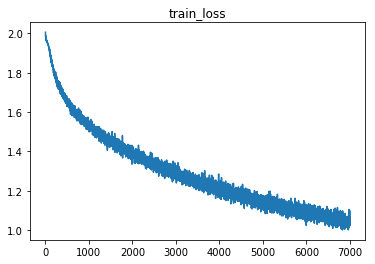

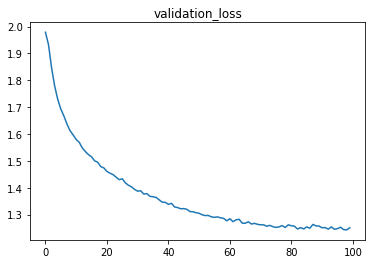

In [11]:
plt.plot(np.arange(0, len(train_loss), 1), train_loss)
plt.title("train_loss")
plt.show()

plt.plot(np.arange(0, len(valid_loss), 1), valid_loss)
plt.title("validation_loss")
plt.show() # train과 validation 모두 봐야 한다.

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

!mkdir gdrive/My\ Drive/vgg
!mv ./model/vgg* gdrive/My\ Drive/vgg
!mv ./model/checkpoint gdrive/My\ Drive/vgg

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
mkdir: cannot create directory ‘gdrive/My Drive/vgg’: File exists
